# Assignment3. #3 Clustering 해보기 : Mall_Customer.csv
https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

1. Preprocessing EDA
2. Clustering ( 수업시간에 배운 세 가지 방법 + α )
3. Evaluation

---

## 1. Preprocessing, EDA

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_palette("hls")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기
mall_df = pd.read_csv('Mall_Customers.csv')
mall_df.head()
del mall_df['CustomerID']

In [3]:
# row 200개
# col 5개 (ID, 성별, 나이, 연간소득, 소비지수)
mall_df.shape

(200, 4)

In [4]:
# gender 제외 모두 수치형
mall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.3+ KB


In [5]:
# 거리 계산 위해 gender는 one-hot encoding 해주기
mall_df['Gender'].replace({'Male':0, 'Female':1}, inplace=True)

In [6]:
# Age : 중위수 < 평균 -> 우측 꼬리 길다
# Annual Income : 평균, 중위수 비슷 -> 좌우대칭 예상
# Spending Score : 평균 = 중위수 -> 좌우대칭 예상
mall_df.describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.560000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,1.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [7]:
# 결측치는 없다
mall_df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
# kmeans, dbscan 등은 거리기반 알고리즘이기 때문에 단위의 영향력을 제거하기 위해 표준화 진행
# 여기서는 (x-mean)/std로 변환하여 평균0, 표준편차1로 scaling을 맞춰주는 standardScaler를 사용하였다.
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
mall_scaled_df = pd.DataFrame(standard_scaler.fit_transform(mall_df), columns=mall_df.columns) # scaled된 데이터

---------- 성별 성비 ----------
1    0.56
0    0.44
Name: Gender, dtype: float64
-------------------------------


([<matplotlib.axis.XTick at 0x1654c9fcef0>,
 <a list of 2 Text xticklabel objects>)

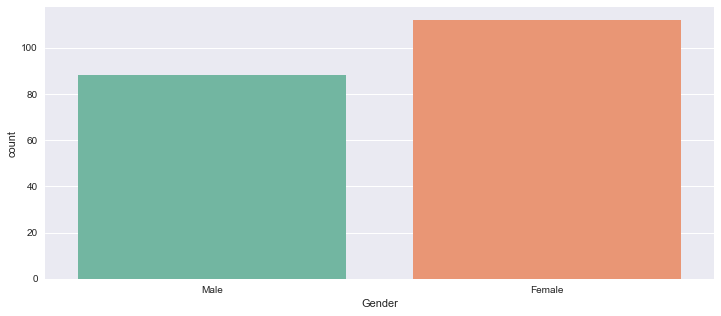

In [9]:
# 성별 성비를 확인해보고자 한다.
# 약간 여성의 데이터가 많다. 
print('---------- 성별 성비 ----------')
print(mall_df['Gender'].value_counts() / mall_df.shape[0])
print('-------------------------------')

plt.figure(figsize=(12, 5))
sns.countplot(mall_df['Gender'], palette='Set2')
plt.xticks([0, 1], ['Male', 'Female'])

mean   > 38.85
median > 36.0


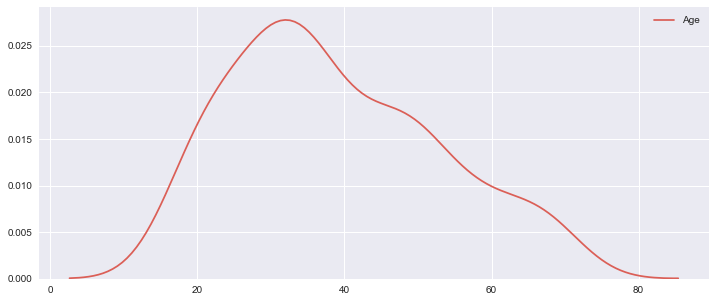

In [10]:
# 연령에 대한 분포는 살짝 우측 꼬리가 긴 형태를 띈다.
plt.figure(figsize=(12, 5))
sns.kdeplot(mall_df['Age'])
print('mean   >', mall_df['Age'].mean())
print('median >', mall_df['Age'].median())

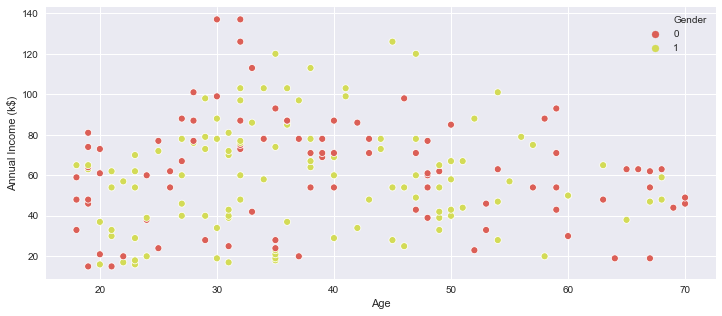

In [11]:
# x축은 나이, y축은 소득으로 scatter plot을 그려보았다.
# 별다르게 cluster로 보이는 부분은 없다
# 전반적으로 age가 증가함에 따라 annual income도 증가하고, 40대를 넘어서면서부터 annual income이 감소하는 형태는 보인다.
plt.figure(figsize=(12, 5))
sns.scatterplot(x='Age', y='Annual Income (k$)', data=mall_df, hue='Gender')

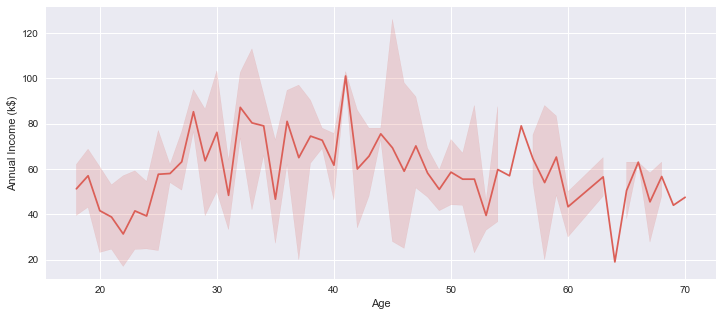

In [12]:
# Age의 변화에 따라 Annual Income의 변화를 scatter plot이 아닌 lineplot으로도 확인해보았다.
plt.figure(figsize=(12, 5))
sns.lineplot(x='Age', y='Annual Income (k$)', data=mall_df)

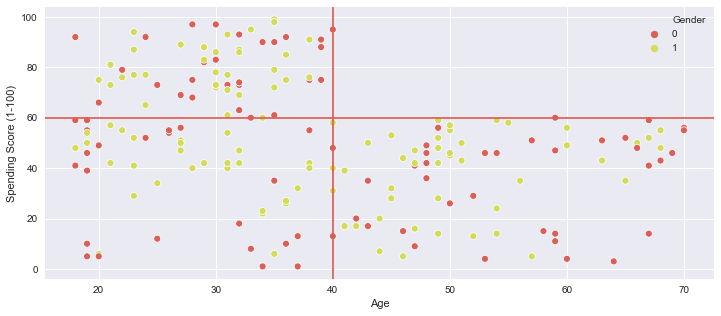

In [13]:
# x축은 나이, y축은 소비수준으로 scatter plot을 그려보았다.
# age가 20~40대 사이인 경우 spending score의 분포가 매우 넓다 (적게 소비하는 층부터 많은 소비를 하는 층까지)
# 하지만 age가 40대를 넘어서면서부터 spending score의 분포가 급격히 줄어든다 (spending score가 60을 넘지 않고 밑돈다)
# 이 부분에서 어느 정도 clustering이 이뤄질 수 있지 않을까 생각해본다.

plt.figure(figsize=(12, 5))
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=mall_df, hue='Gender')
plt.axvline(40, 0, 100)
plt.axhline(60, 0, 80)

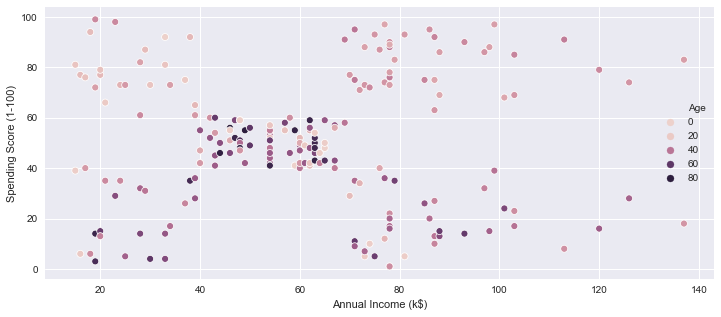

In [14]:
# 여기서 5개의 군집이 보이는 것 같다.
# Annual income 낮고, spending score도 낮은 경우 -> 0~20대 사이  
# Annual income 낮고, spending score은 높은 경우 -> 20~60 사이
# Annual income 보통, spending score도 보통 -> 고른 연령대
# Annual income 높고, spneding score 낮은 경우 -> 40~80대 사이
# Annual income 높고, spending score 높은 경우 -> 20~40대 사이

plt.figure(figsize=(12, 5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_df, hue='Age')

In [15]:
# 실제 데이터는 3차원이지만 우리가 시각화한 내용은 2차원이다.
# 따라서 3차원으로 시각화했을 때는 또 다른 군집이 보일 수 있을 것으로 예상된다.
# 대략적인 preprocessing과 EDA는 이정도에서 마무리하고, 실제 clustering을 수행해보도록 하자.

## 2. Clustering
ML은 크게 supervised learning, unsupervised learning, reinforcement learning으로 나뉘는데,  
clustering은 target이 존재하지 않는 unsupervised learning에 속한다.  

clustering에 대한 전체적인 구분은 아래와 같다.

- clustering
1. hierarchical clustering (중첩 허용)  
    거리측정 방식(L1 norm, L2 norm, mahalanobis, corr distance 등) + 군집과 군집 사이 거리(single, complete, average, centroid, ward)
    - bottom up ex) AgglomerativeClustering -> proximity matrix에서 점점 군집의 크기를 키워나감 
    - top down
2. partitional clustering (중첩 비허용)
    - 거리 기반 ex) KMeans (결정해야 하는 것 : K + 초기 centroid의 위치)
    - 밀도 기반 ex) DBSCAN (결정해야 하는 것 : eps + minpts)

### 1) Hierarchical Clustering
중복을 허용하여 clustering 하는 방법 (=군집 내에 군집이 속할 수 있음)
일정 높이에서 dendrogram을 잘라서 군집의 수 결정한다.

1. 거리를 측정하는 방법
    - L1 norm (manhattan distance)
    - L2 norm (euclidean distance)
    - mahalanobis (feature간의 공분산 행렬을 고려한 거리)
    - corr distance (상관계수 높을수록 거리 짧게)
2. cluster 간의 거리를 측정하는 방법
    - single linkage (군집 간 element끼리의 거리 중 min을 군집 간 거리로 설정)
    - complete linkage (군집 간 element끼리의 거리 중 max를 군집 간 거리로 설정)
    - average linkage (군집 간 element끼리의 모든 거리를 average)
    - centroid (군집의 centroid끼리의 거리)
    - ward (두 군집 간 제곱합 - (군집  내 제곱합의 합))

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

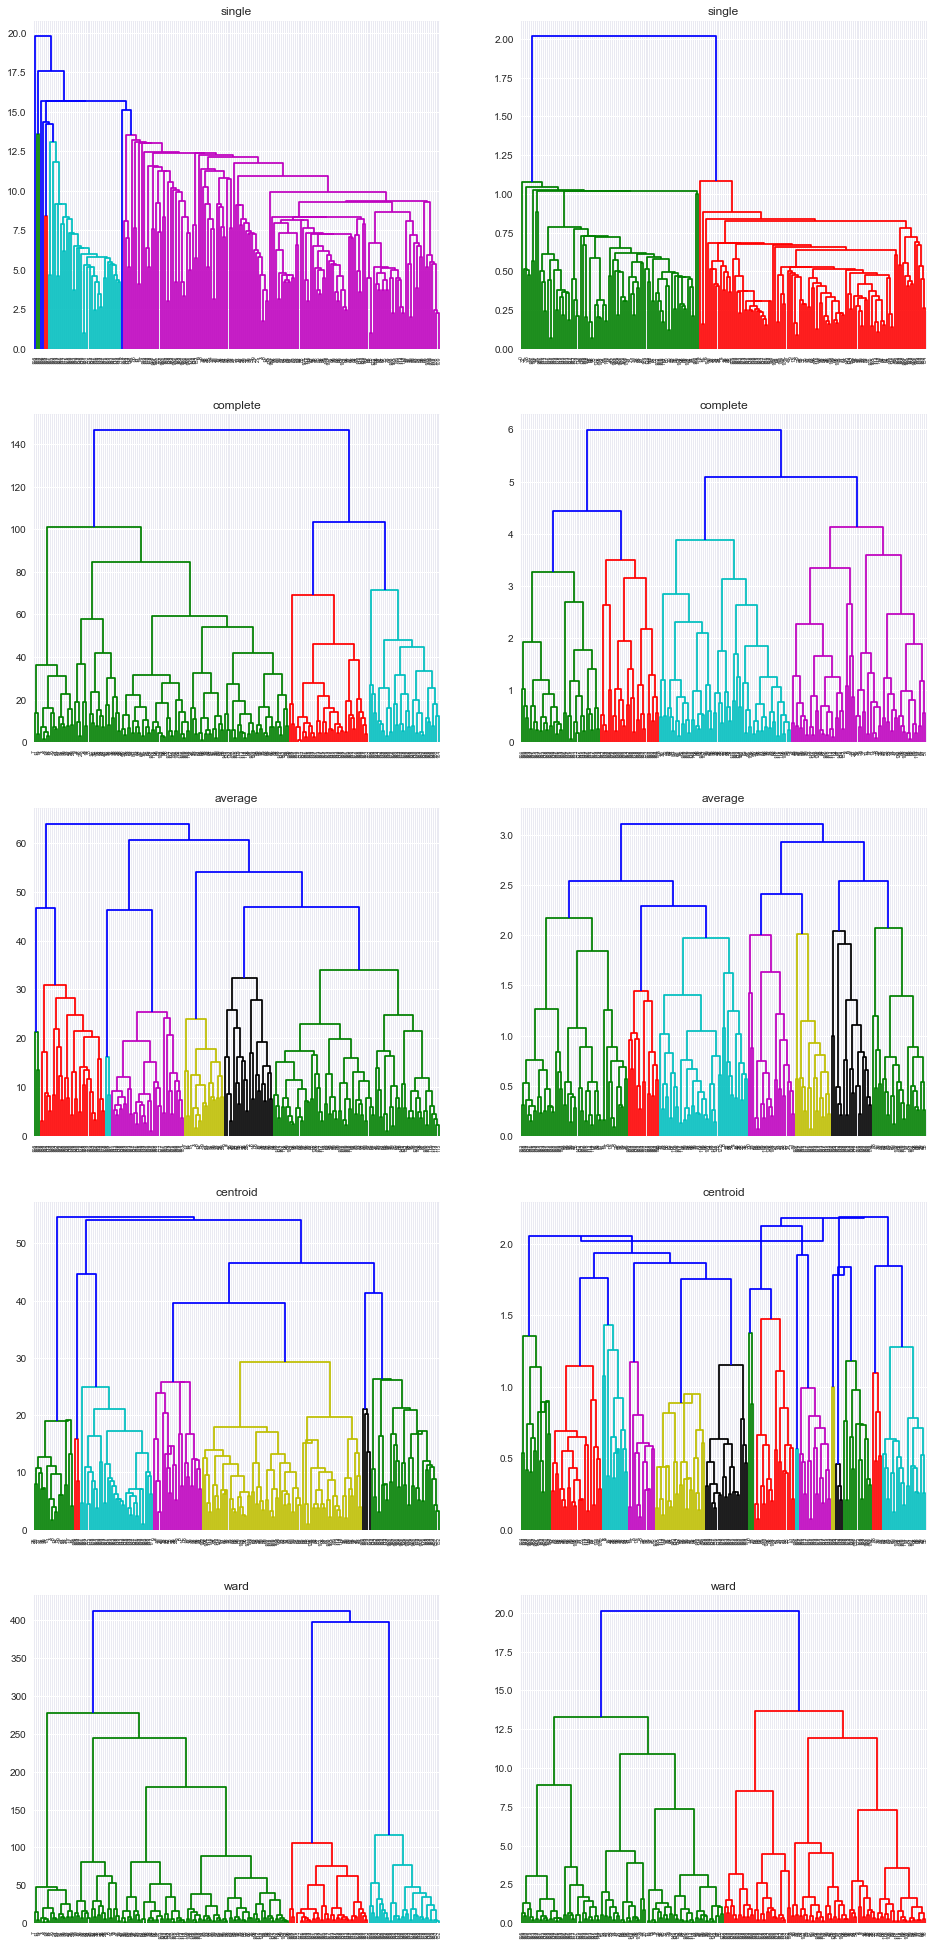

In [17]:
# 왼쪽은 scaling 적용 X 데이터, 오른쪽은 scaling 적용 O 데이터
# 순서대로 single linkage, complete linkage, average linkage, centroid linkage, ward linkage 적용해보았다.
# 거리를 기준으로 proximity matrix를 만들고 이에 따라 cluster를 키워 나가는데,
# 군집 간 거리를 측정하는 방식이 달라지니 군집화가 이루어진 결과도 확연히 차이가 났다.

linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']
data = [mall_df, mall_scaled_df]

fig, axes = plt.subplots(nrows=len(linkage_list), ncols=2, figsize=(16, 35))
for i in range(len(linkage_list)):
    for j in range(len(data)):
        hierarchical_single = linkage(data[j], method=linkage_list[i])
        dn = dendrogram(hierarchical_single, ax=axes[i][j])
        axes[i][j].title.set_text(linkage_list[i])
plt.show()

In [18]:
# 위의 dendrogram 결과 중 average가 비교적 균일하게 군집화가 이루어진 것 같아 
# cluster가 5가 되도록 클러스터링을 해보았다.
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='average')
labels = agg_clustering.fit_predict(mall_df)

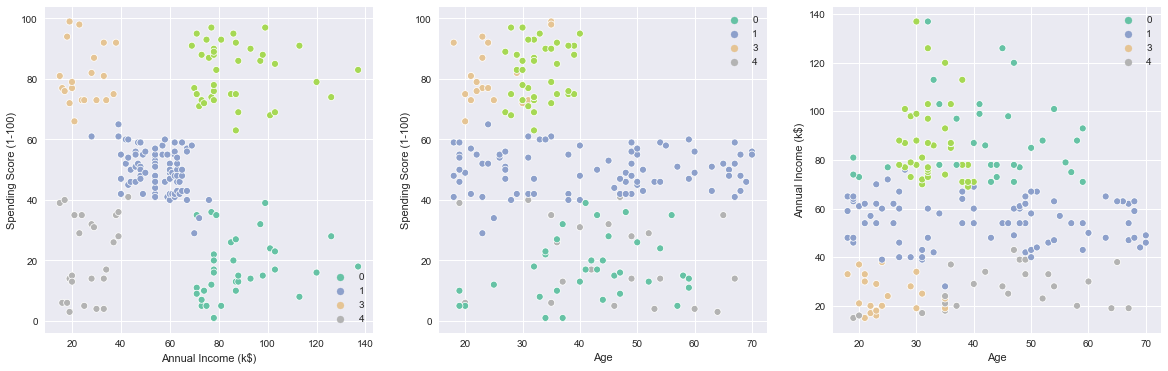

In [19]:
# scaling하기 전의 데이터로 hierarchical clustering(method='average', n_cluster=5) 결과
# 어느 정도 군집화가 잘 되어보있다. (내부평가는 뒤의 3. evaluation에서 진행해보겠다.)
plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_df, hue=labels, palette='Set2')

plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=mall_df, hue=labels, palette='Set2')

plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=mall_df, hue=labels, palette='Set2')

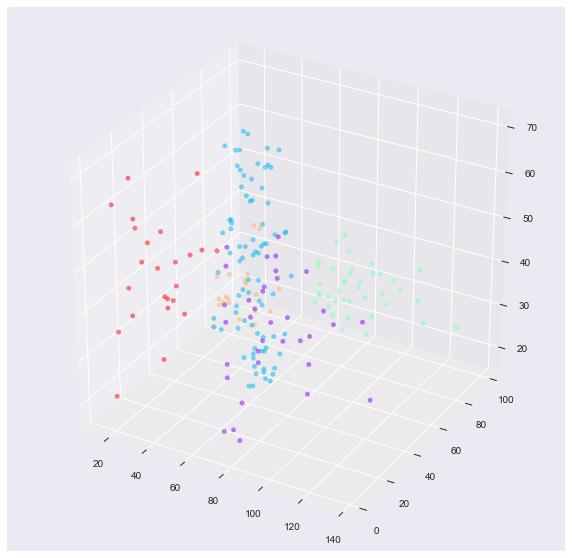

In [20]:
# https://frhyme.github.io/python-lib/matplotlib_3dplotting/
# 위의 clustering 결과를 3차원 시각화
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = mall_df['Annual Income (k$)']
y = mall_df['Spending Score (1-100)']
z = mall_df['Age']
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.5, cmap='rainbow')

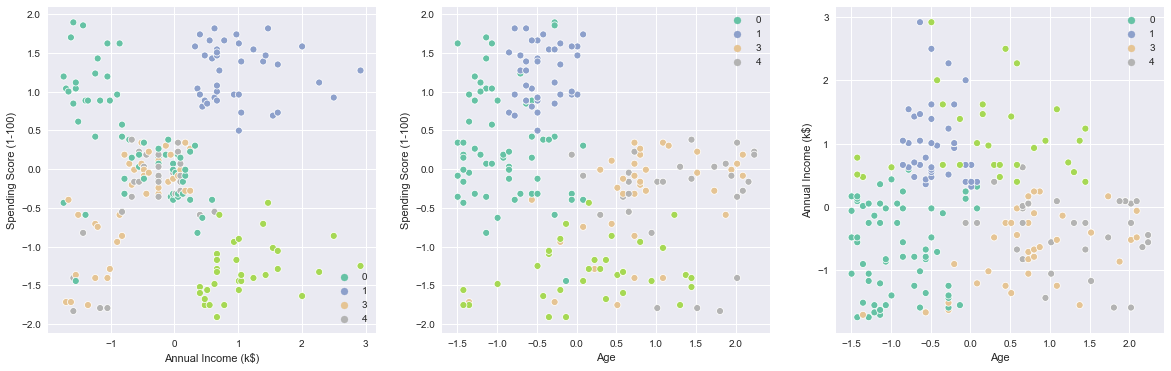

In [21]:
# 이번에는 scaling한 데이터로 계층적군집화를 진행해보았다.
# (ward 방법이 cluster가 비교적 균등하게 성장하여 이 방법을 선택해보았다.)
# 2차원으로 시각화 해보았을 때는 scaling하기 전의 데이터보다 clustering 결과가 안 좋아보인다. (나중에 silhouette score로 확인해보겠다.)

agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels = agg_clustering.fit_predict(mall_scaled_df)

plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_scaled_df, hue=labels, palette='Set2')

plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=mall_scaled_df, hue=labels, palette='Set2')

plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=mall_scaled_df, hue=labels, palette='Set2')

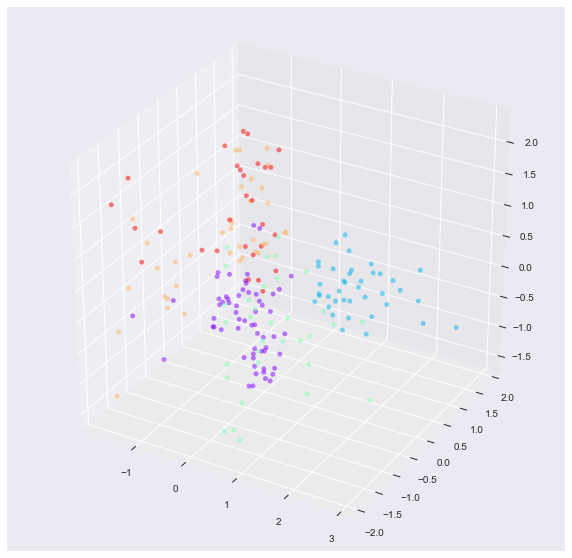

In [22]:
# 위의 clustering 결과를 3차원 시각화
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = mall_scaled_df['Annual Income (k$)']
y = mall_scaled_df['Spending Score (1-100)']
z = mall_scaled_df['Age']
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.5, cmap='rainbow')

### 2) KMeans
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html (공식문서)  
https://lovit.github.io/nlp/machine%20learning/2018/03/19/kmeans_initializer/ (k-means++ 설명)  

kmeans는 비계층적 군집화 방법 중 distance 기반 알고리즘에 속한다.  
kmenas는 k개의 init centroid를 설정해놓고, 각각의 데이터를 가까운 centroid cluster로 할당한 후,   
그리고 cluster 내 centorid를 update하고, 다시 각각의 데이터를 가까운 centroid cluster로 할당하는 과정을 반복한다.  
이 과정을 centorid가 변하지 않을 때 까지 반복 수행된다. (=즉 각 centroid cluster에 할당된 데이터가 더이상 변하지 않을 때 까지)  
(혹은 iteration 횟수를 지정해두기도 한다.)  

kmeans에서 중요한 변수는 군집의 개수인 **K**와 **init centroid**이다.
init centroid가 어디인지에 따라 최종 수렴된 clustering 결과가 달라질 수 있기 떄문에  
일부 데이터를 sampling해 hierarchical clusteirng을 수행한 후, 이에 기반해 init centorid를 지정하기도 한다.  
scikit learn의 KMeans ‘k-means++’ 방법으로 초기 centroid를 결정하는데,   
이 방법은 k개의 초기 centroid를 결정할 때 centroid_1 하나 지정하고 그 다음 centorid_2는 **이전의 centroid_1와 멀리 떨어지게 잡는 것**이다.  
또한 군집의 수인 K는 x축을 K, y축을 군집 내 거리 제곱합의 합으로 두고 급격하게 꺽이는 elbow point를 찾는다.  
(=당연히 군집의 수 늘어날수록 군집 내 거리제곱합은 줄어드는 것이다. elbow point를 찾는 이유는 군집의 수를 늘렸음에도 불구하고 거리제곱합이 크게 줄어들지 않는 지점을 찾고자 하는 의도)

In [23]:
from sklearn.cluster import KMeans

In [24]:
# k에 따라 inertia_(군집 내 거리제곱합의 합)이 어떻게 변하는 지 시각화
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(mall_df)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

In [25]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

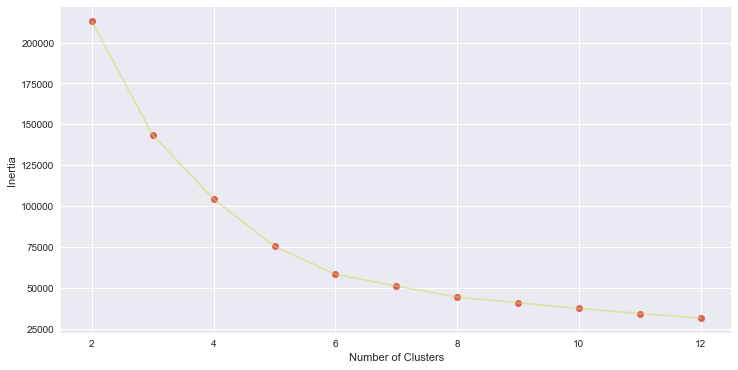

In [26]:
# sacling하지 않은 데이터
# 6 정도가 elbow point로 보인다.
change_n_clusters(n_clusters, mall_df)

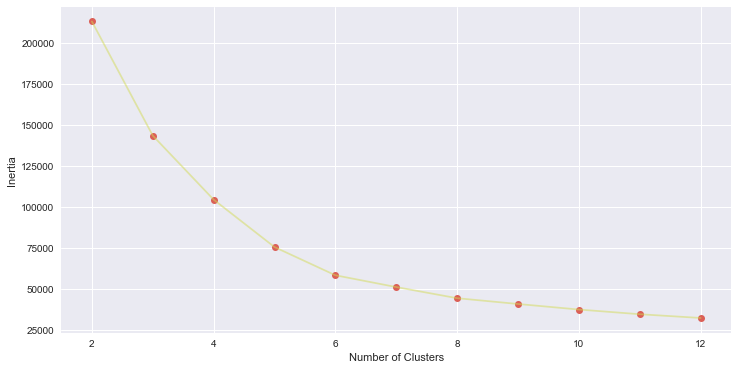

In [27]:
# sacling 수행한 데이터
# 6 정도가 elbow point로 보인다.
change_n_clusters(n_clusters, mall_scaled_df)

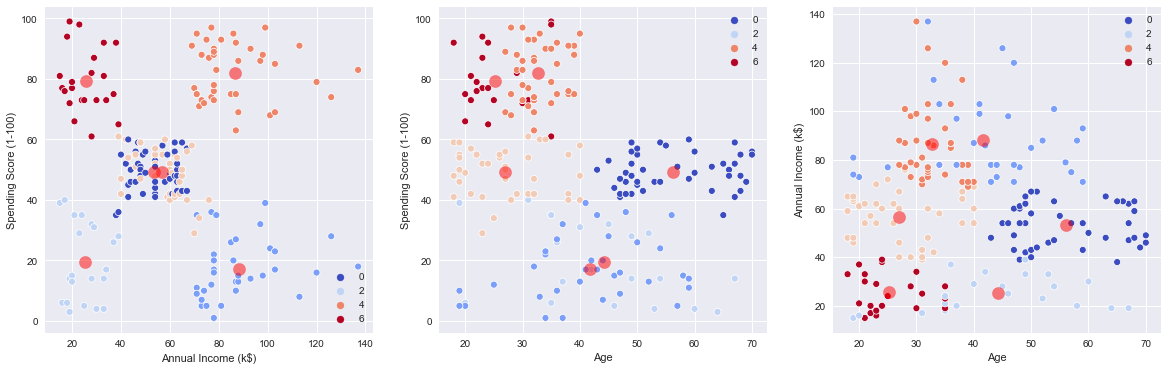

In [28]:
# scaling하지 않은 데이터를 kmeans(k=6)으로 학습하고 시각화
# 어느정도 군집화가 잘 된 것으로 보여진다.

kmeans = KMeans(n_clusters=6)
kmeans.fit(mall_df)

plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_df, hue=kmeans.labels_,palette='coolwarm')
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], c='red', alpha=0.5, s=150)

plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=mall_df, hue=kmeans.labels_, palette='coolwarm')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 3], c='red', alpha=0.5, s=150)

plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=mall_df, hue=kmeans.labels_, palette='coolwarm')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', alpha=0.5, s=150)

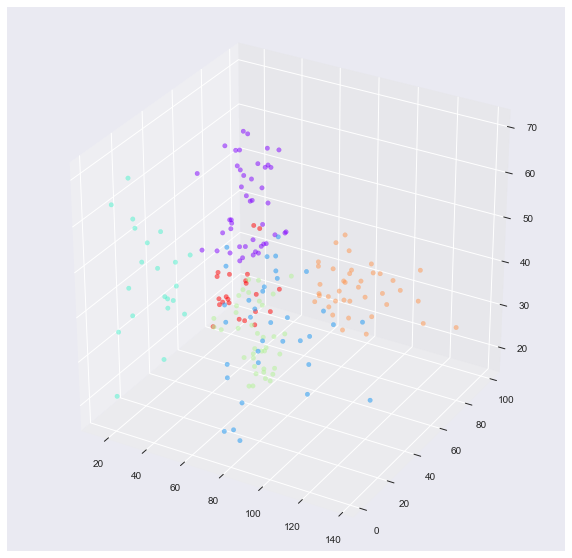

In [29]:
# https://frhyme.github.io/python-lib/matplotlib_3dplotting/
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = mall_df['Annual Income (k$)']
y = mall_df['Spending Score (1-100)']
z = mall_df['Age']
ax.scatter(x, y, z, c = kmeans.labels_, s= 20, alpha=0.5, cmap='rainbow')

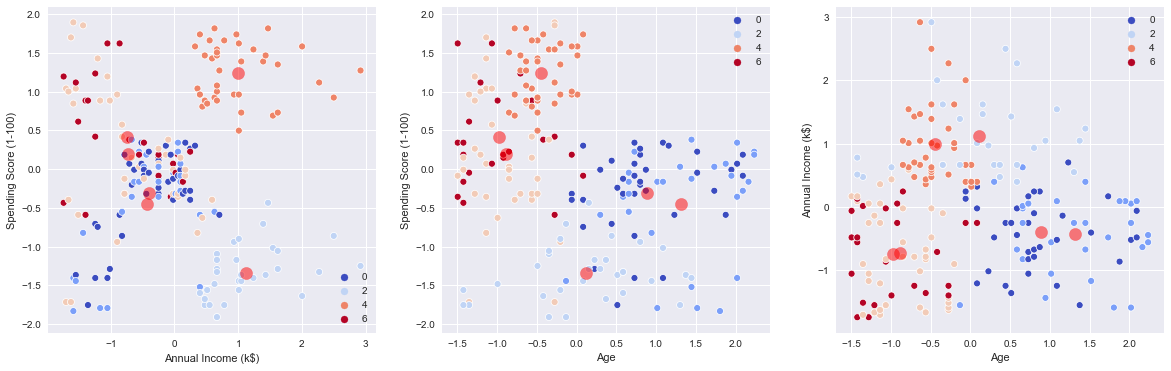

In [30]:
# scaling한 데이터를 kmeans(k=6)으로 학습하고 시각화
# 어느정도 군집화가 잘 된 것으로 보여진다. (scaling 전의 데이터보다는 안 좋아 보이기도 한다 -> 나중에 silhouette score로 평가해보도록 하자.)

kmeans = KMeans(n_clusters=6)
kmeans.fit(mall_scaled_df)

plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_scaled_df, hue=kmeans.labels_,palette='coolwarm')
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], c='red', alpha=0.5, s=150)

plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=mall_scaled_df, hue=kmeans.labels_, palette='coolwarm')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 3], c='red', alpha=0.5, s=150)

plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=mall_scaled_df, hue=kmeans.labels_, palette='coolwarm')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', alpha=0.5, s=150)

### 3) DBSCAN
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

dbscan은 clustering 방법 중 partitional clustering에 속하며 밀도 기반 알고리즘이다.  
dbscan에서 중요한 hyperparameter는 minpts와 eps이다.  

dbscan은 eps, minpts에 기반하여 모든 데이터를 core point, border point, noise point로 구분한다.  
- **core point** : eps 반경 내에 minpts 이상개의 데이터 보유
- **border point** : eps 반경 내에 minpts개의 데이터는 없지만, core point를 neighbor로 가진다.
- **noise point** : eps 반경 내에 minpts개의 데이터도 없고, core point도 neighbor로 가지지 않는다.

core point가 다른 core point의 eps 반경내에 포함되면 하나의 cluster가 되는 방향으로 군집을 형성해 나간다.    
이 때 border point는 cluster의 경계를 형성하는 역할을 하며, noise point는 어떠한 cluster에도 포함되지 않는다.  

eps와 minpts는 k-dist를 통해 적절한 값이 결정된다.  
각 데이터마다 k번째로 가까운 거리를 구하고, 이 거리를 정렬하여 plot을 그린다.  
이 때 급격히 k-dist가 증가할 때 이 때의 dist값이 eps가, k가 minpts가 된다.  
(이렇게 되면 대부분의 경우 eps 반경내에 k개의 데이터를 갖고 있다는 의미)  

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

18.193405398660254


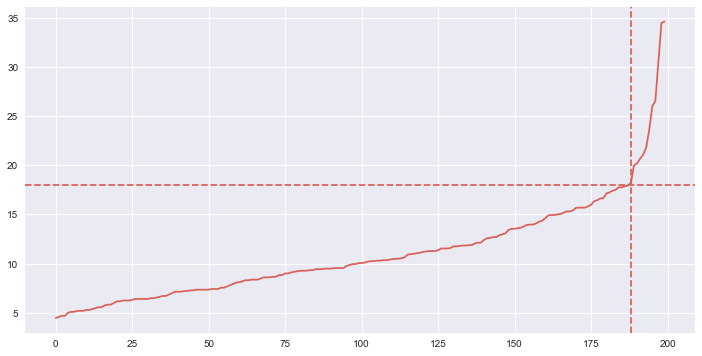

In [32]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(mall_df)
distances, indices = neigh.kneighbors(mall_df) # 각 개체마다 거리를 계산해서 가까운 거리의 5개와 그 떄의 index 반환

# 4-dist를 plotting 해보기
# 저 빨간점에서 급격히 4-dist가 급증하였다 -> 우리는 이 때의 distance인 18을 eps로, 4를 minpts로 잡고 DBSCAN을 진행해보도록 하자.
plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(188, 0, 2, ls='--')
plt.axhline(18, 0, 200, ls='--')

print(np.sort(distances[:, 4])[188])

[-1  0]


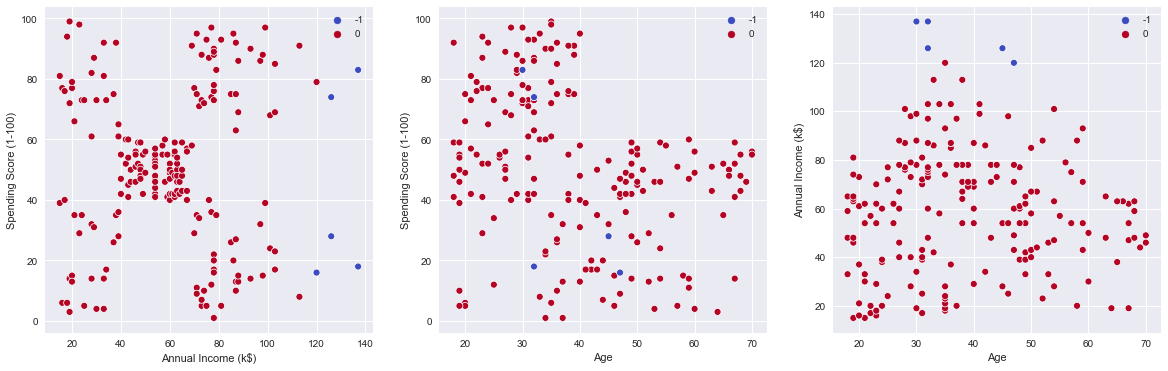

In [33]:
dbscan = DBSCAN(eps=18, min_samples=4) # scaling 하지 않은 데이터로 DBSCAN 학습
dbscan.fit(mall_df)

print(np.unique(dbscan.labels_))

plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_df, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=mall_df, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=mall_df, hue=dbscan.labels_, palette='coolwarm')

# DBSCAN은 밀도가 급격히 변할 때 군집을 잘 인식하지 못하는데, 이 데이터가 그러하여 군집을 잘 찾지 못한 것 같다.
# (촘촘한 밀도를 고려하지 못하고 전체를 하나의 군집으로 인식)
# 실제로 DBSCAN한 결과 1개의 cluster만 형성되었다. (-1은 noise point이다.)
# 이 데이터에는 DBSCAN이 적합하지 않은 것으로 예상된다.

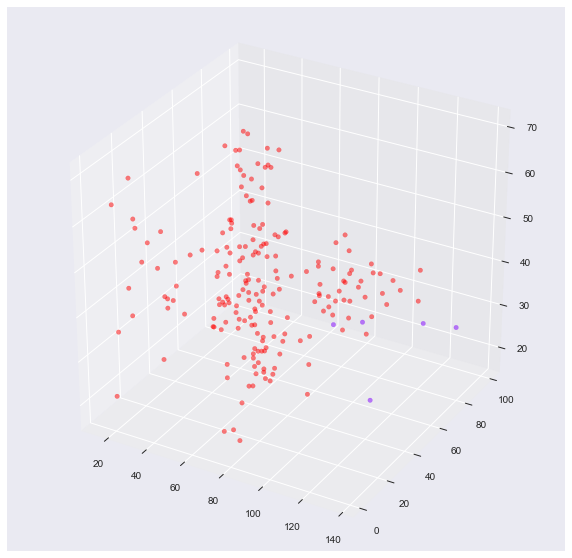

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = mall_df['Annual Income (k$)']
y = mall_df['Spending Score (1-100)']
z = mall_df['Age']
ax.scatter(x, y, z, c = dbscan.labels_, s= 20, alpha=0.5, cmap='rainbow')

1.0792036945604633


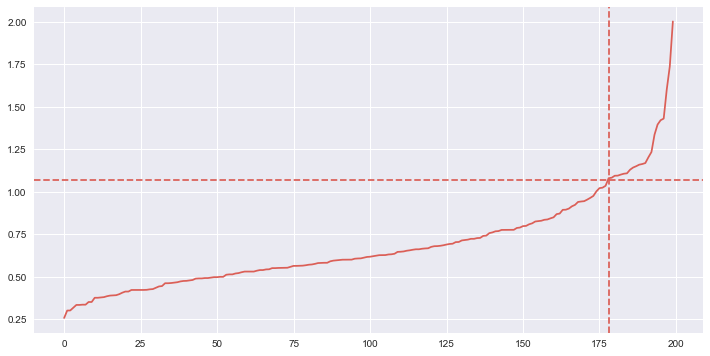

In [35]:
# 이번에는 scaling한 데이터로 DBSCAN을 진행해보고자 한다.
# 그래프에서 급격히 4-dist가 증가하는 지점에서 eps를 설정하도록 한다. (여기서는 1.07일 때 급격히 증가한다)

neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(mall_scaled_df)
distances, indices = neigh.kneighbors(mall_scaled_df)

plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(178, 0, 2, ls='--')
plt.axhline(1.07, 0, 200, ls='--')

print( np.sort(distances[:, 4])[178] )

[-1  0  1]


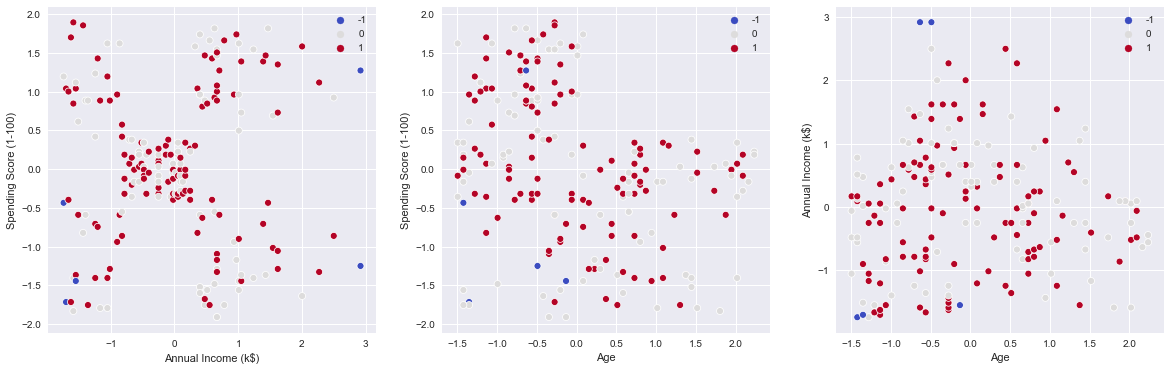

In [36]:
dbscan = DBSCAN(eps=1.07, min_samples=4) # 위에서 구한 eps와 minpts로 scaling된 데이터 DBSCAN 학습
dbscan.fit(mall_scaled_df)
print(np.unique(dbscan.labels_))

plt.figure(figsize=(20, 6))
plt.subplot(131)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_scaled_df, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(132)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=mall_scaled_df, hue=dbscan.labels_, palette='coolwarm')
plt.subplot(133)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=mall_scaled_df, hue=dbscan.labels_, palette='coolwarm')

# 2개의 군집으로 분류되었지만 위와 비슷하게 대부분 clsuter 1에 속한다.
# 아무대로 군집 별 밀도가 일정하지 않아 결과가 좋지 않은 것으로 예상된다.

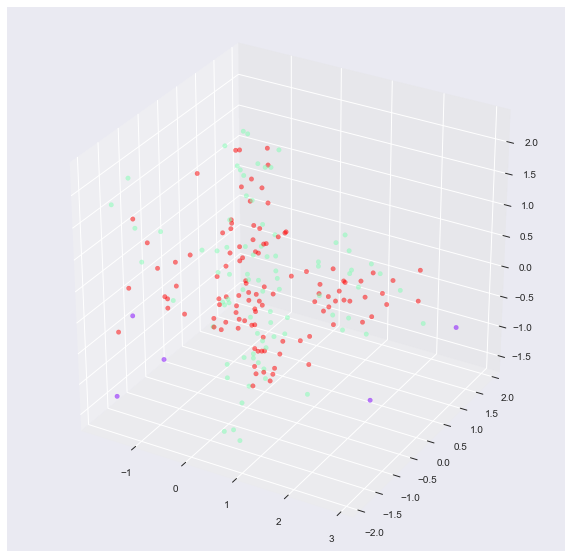

In [37]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = mall_scaled_df['Annual Income (k$)']
y = mall_scaled_df['Spending Score (1-100)']
z = mall_scaled_df['Age']
ax.scatter(x, y, z, c = dbscan.labels_, s= 20, alpha=0.5, cmap='rainbow')

### 4) 
`spectralClustering`   
https://towardsdatascience.com/unsupervised-machine-learning-spectral-clustering-algorithm-implemented-from-scratch-in-python-205c87271045
1. Construct a similarity graph  
2. Determine the Adjacency matrix W, Degree matrix D and the Laplacian matrix L  
3. Compute the eigenvectors of the matrix L  
4. Using the second smallest eigenvector as input, train a k-means model and use it to classify the data  


`Meanshift`   
KDE(kernal density estimation)을 이용하여 데이터 포인트들이 분포가 높은 곳으로 이동하며 clustering이 수행된다.
**별도의 cluster 개수를 지정하지 않으며** 데이터 분포도에 기반하여 자동으로 cluster 개수가 정해짐  

KDE는 kernal 함수를 통해 어떤 변수의 **확률밀도 함수를 추정**하는 방식이다.
확률 밀도를 추정하는 방식에는 모수적 방식과 비모수적 방식이 있는데, KDE는 비모수적 방식에 속한다. (모수적 방식은 분포를 가정하고 그 때의 모수를 추정하는 방식)  
KDE는 개별 데이터에 커널 함수를 적용한 뒤 커널함수의 적용 값을 합한 후 데이터의 건수로 나누어 확률밀도함수를 추정하는 방식이다. (커널함수로는 가우시안 분포함수가 대표적이다.)   
meanshift에서 주요 hyperparameter는 **bandwidth**인데,  
만약 가우시안 커널 함수를 사용한다고 했을 때 bandwidth가 작으면 표준편차가 작은 커널함수가 만들어진다.  
따라서 **bandwidth가 작으면 overfitting**될 확률이 높고, **bandwidth가 작으면 smoothing되어 underfitting**될 확률이 높다.  
또한 bandwidth가 작을수록 많은 클러스터 중심점을, 클수록 적은 클러스터 중심점을 갖게 된다.  


In [38]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [39]:
# 적절한 bandwidth 계산
bandwidth = estimate_bandwidth(mall_df)
print('bandwidth 값:', round(bandwidth,3))

meanshift = MeanShift(bandwidth=bandwidth)
labels = meanshift.fit_predict(mall_df)

print(labels)

bandwidth 값: 40.169
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [40]:
bandwidth = estimate_bandwidth(mall_scaled_df)
print('bandwidth 값:', round(bandwidth,3))

meanshift = MeanShift(bandwidth=bandwidth)
labels = meanshift.fit_predict(mall_scaled_df)

print(labels)

bandwidth 값: 2.256
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 3. Evaluation

In [41]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math

In [42]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(clustering, X_features, cluster_lists=[1]): 
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        if clustering[0] == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_cluster, linkage=clustering[1])
        elif clustering[0] == 'kmeans':
            model = KMeans(n_clusters=n_cluster)
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        cluster_labels = model.fit_predict(X_features)
        
        #if clustering[0] == 'dbscan':
        #    n_cluster = len(set(cluster_labels))-1
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([-1, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [43]:
params = {
    'linkage':['single', 'complete', 'average', 'ward'],
    'n_clusters':[2, 3, 4, 5, 6, 7]}

scores_hierarcical= {}
for linkage in params['linkage']:
    for n_cluster in params['n_clusters']:
        hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        hierarchical.fit(mall_df)
        score = silhouette_score(mall_df, hierarchical.labels_)
        scores_hierarcical['_'.join(['original', linkage, str(n_cluster)])] = score
        
        hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        hierarchical.fit(mall_scaled_df)
        score = silhouette_score(mall_scaled_df, hierarchical.labels_)
        scores_hierarcical['_'.join(['scaling', linkage, str(n_cluster)])] = score

pd.Series(scores_hierarcical).sort_values(ascending=False)[:10]

# 전반적으로 scaling을 적용한 후에 silhouette score가 낮아졌다.
# 아무래도 scaling하기 전의 척도가 군집화를 수행함에 있어 적절했던 것으로 예상된다.
# (데이터마다 scaling이 좋을수도, 나쁠수도 있다.)

original_ward_6        0.442801
original_ward_5        0.439975
original_complete_5    0.439975
original_average_5     0.435211
original_ward_7        0.425939
original_complete_6    0.423266
original_average_6     0.418404
original_complete_7    0.414121
original_complete_4    0.410209
original_ward_4        0.410209
dtype: float64

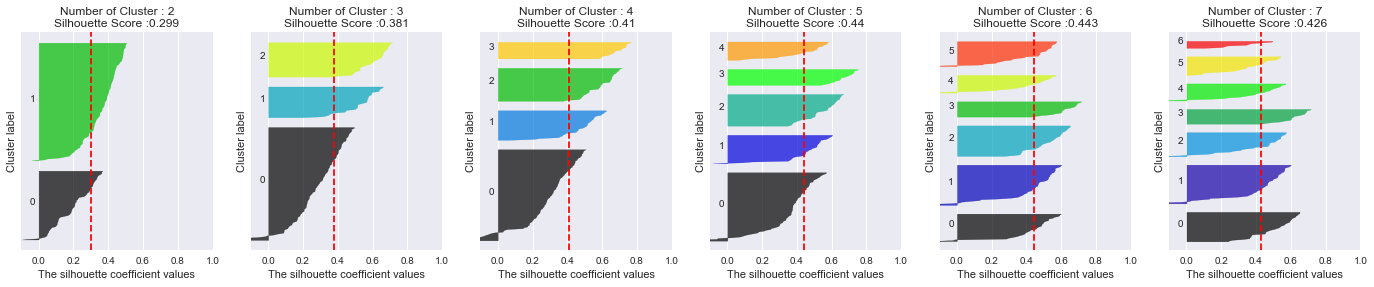

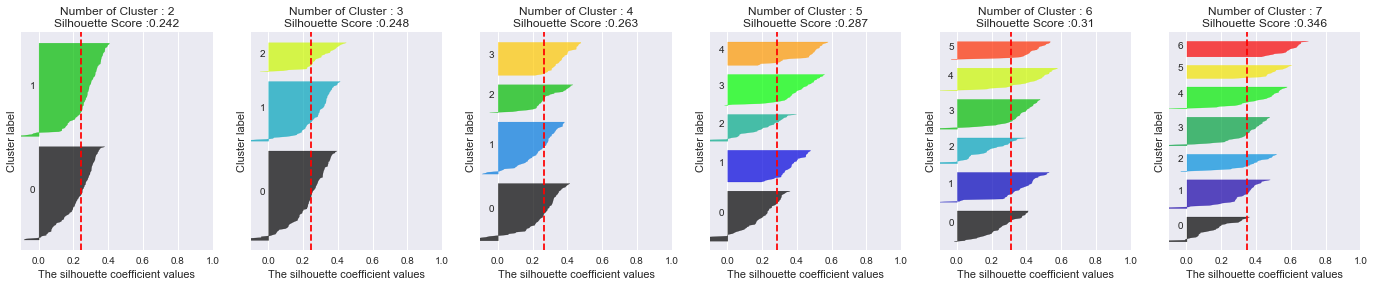

In [44]:
# 위의 결과를 바탕으로 silhouette score를 확인해보았다.
# 실루엣 지수 해석 시 silhouette score만 좋다고 해서 좋은 clustering이라고 판단하면 안된다.
# 한 cluster silhouette 지수가 좋아서 전반적인 silhouette score가 높은 것이라면 그것은 clustering이 잘 되었다고 해석하기에는 무리가 있기 때문이다.

# 아래의 그림을 보면 cluster=6일 때 silhouette score가 높지만 5일 때도 유사하게 높으며 또한 5개의 cluster로 분류된 경우 전반적으로 모든 cluster의 실루엣 지수가 높다.
# 6개보다 5개로 군집화 했을 경우 silhouette 지수가 음수인 경우가 드물어 보인다.
# 따라서 무작정 군집의 수를 6으로 설정하기 보다는 5개인 경우와 6개인 경우를 모두 시각화해보고 적절해보이는 결과를 채택하는 것이 옳아 보인다.

visualize_silhouette(['hierarchical', 'ward'], mall_df, [2, 3, 4, 5, 6, 7]) # 위가 original data
visualize_silhouette(['hierarchical', 'ward'], mall_scaled_df, [2, 3, 4, 5, 6, 7]) # 아래가 scaled data

In [45]:
params = {'n_clusters':[2, 3, 4, 5, 6, 7]}

scores_kmeans = {}
for n_cluster in params['n_clusters']:
    model = KMeans(n_clusters=n_cluster)
    model.fit(mall_df)
    score = silhouette_score(mall_df, model.labels_)
    scores_kmeans['_'.join(['original', str(n_cluster)])] = score
    
    model = KMeans(n_clusters=n_cluster)
    model.fit(mall_scaled_df)
    score = silhouette_score(mall_scaled_df, model.labels_)
    scores_kmeans['_'.join(['scaled', str(n_cluster)])] = score

pd.Series(scores_kmeans).sort_values(ascending=False)[:10]

# 계층적 군집화와 마찬가지로 전반적으로 scaling을 적용한 후에 silhouette score가 낮아졌다 

original_6    0.452055
original_5    0.440237
original_7    0.439992
original_4    0.405295
original_3    0.383799
scaled_7      0.362087
scaled_6      0.324796
scaled_5      0.317091
scaled_4      0.301624
original_2    0.293073
dtype: float64

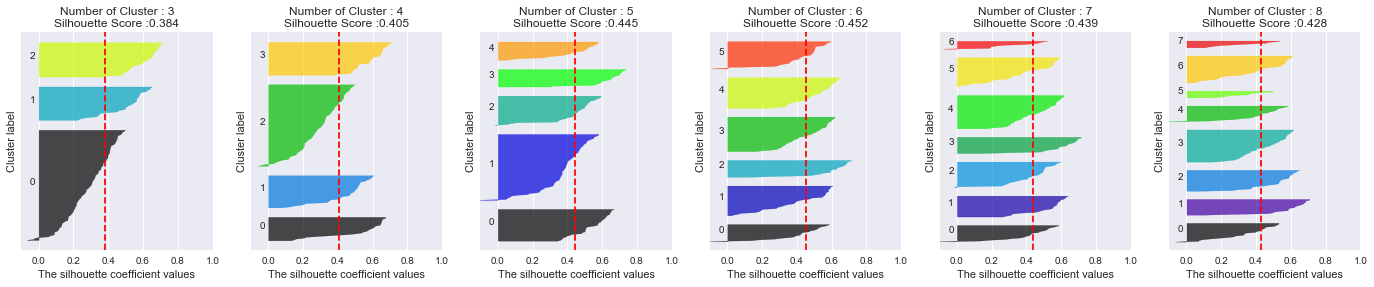

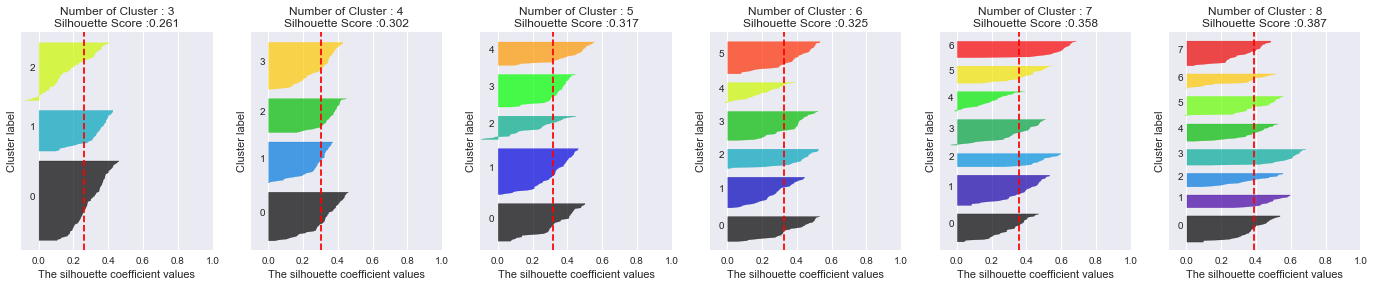

In [46]:
visualize_silhouette(['kmeans'], mall_df, [3, 4, 5, 6, 7, 8])
visualize_silhouette(['kmeans'], mall_scaled_df, [3, 4, 5, 6, 7, 8])

In [65]:
from sklearn.metrics import silhouette_score

dbscan = DBSCAN(eps=18, min_samples=4)
dbscan.fit(mall_df)
print( silhouette_score(mall_df, dbscan.labels_) ) # 실제로는 1개의 군집이기 때문에 silhouette score가 계산이 안되어야 한다고 생각한다.
# print(print( silhouette_score(mall_df[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]) )) # noise 제외한 silhouette score

dbscan = DBSCAN(eps=1.07, min_samples=4)
dbscan.fit(mall_scaled_df)
print( silhouette_score(mall_scaled_df, dbscan.labels_) ) # noise를 하나의 군집으로 여기고 silhouette score 계산 (인 것 같다)
print( silhouette_score(mall_scaled_df[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]) ) # noise 제외한 silhouette score

# original data에서 DBSCAN은 하나의 cluster만 만들고, scaled data에서는 두 개의 cluster를 만들었었다.
# 실제 시각화 결과에서도 딱히 군집화가 잘 되었다고 생각하지 않았는데, silhouette score 역시 높지 않다.
# hierarchical clustering이나 KMeans에 비해 silhouette score가 낮은 것으로 보아 본 데이터에는 DBSCAN이 적합하지 않은 것으로 보인다.
# (아무래도 일정한 밀도를 유지하고 있는 데이터가 아니기 때문이지 않을까?)

0.3730324614703765
0.2652046618498847
0.2835273023622371
